In [2]:
# import Pkg; Pkg.add("DataFrames")
using KrylovKit
include("ed.jl")
using .observables

# Perturbation theory vs Mathieu function

For this analysis, consider the Hamiltonian
$$H=-\frac{\partial^2}{\partial \phi^2} + g\cos \phi$$
$$\tilde{H}=\cos \phi-\frac{1}{g}\frac{\partial^2}{\partial \phi^2}$$
The eigenvalue equation for this is
$$\cos \phi \psi-\frac{1}{g}\frac{\partial^2 \psi}{\partial \phi^2}=\tilde{E}\psi=\frac{E}{g}\psi$$
$$\frac{\partial^2 \psi}{\partial \phi^2}+g(\tilde{E}-\cos\phi)\psi=0$$
This is in the form of the Mathieu equation where $q=g/2$ and $a=g\tilde{E}=E$

In [115]:
using MathieuFunctions
using Plots

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))
k_values = []
g_values = 10 .^(0:0.1:9)
for g in g_values
    # println(collect(Iterators.flatten(f(g/2)))[1]/g+1)
    eigenvalue = Complex(collect(Iterators.flatten(f(g/2)))[1]+ g)
    # println(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3)))
    push!(k_values, real(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3))))
end

plot(g_values, k_values, xlabel="g", ylabel="k", dpi=300)

# k=13
# eigenvalues_pt = -1 + 1/(3g)*k*(k+1)*(2k+1)
# println(eigenvalues, " ", eigenvalues_pt)
savefig("tmp.png")

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\tmp.png"

In [1]:
g = 1e8
println(f(g*2)[1]/4/g)
# -10000 + 5*(5+1)/3

UndefVarError: UndefVarError: `f` not defined

# Hessian diagonalization

In [10]:
Nsites = 2
angle = 0
Estrength = 0
g = 10000


10000

In [11]:
using Symbolics
using LinearAlgebra
using IterTools

# numerically diagonalize hamiltonian
@variables x[1:Nsites]
hamiltonian = g*sum(sin(ϕ_1)*sin(ϕ_2) - 2*cos(ϕ_1)*cos(ϕ_2) for (ϕ_1, ϕ_2) in partition(x,2,1))
# hamiltonian = g*sum(ϕ_1*ϕ_2+ϕ_1^2+ϕ_2^2 -2 for (ϕ_1, ϕ_2) in partition(x,2,1))
ground_energy = substitute(hamiltonian, Dict(y => 0 for y in x)).val
a = substitute(Symbolics.hessian(hamiltonian,[x...]), Dict(y => π for y in x))
a = map(x-> x.val, a)

λ, vecs = eigen(a)

eigenvalues2 = []
for n in Tuple.(CartesianIndices(Tuple(0:7 for i=1:Nsites)))
    # vec = (n .+ 1/2) .* sqrt.(2*λ)  .+ ground_energy/Nsites
    # push!(eigenvalues2,\(A, vec)[end])
    push!(eigenvalues2,sum((n .+ 1/2) .* sqrt.(2*λ)) + ground_energy)
end
sort(eigenvalues2)[1:10]

10-element Vector{Any}:
 -19806.814834742185
 -19665.393478504877
 -19561.86586046387
 -19523.97212226757
 -19420.444504226558
 -19382.550766030257
 -19316.91688618555
 -19279.02314798925
 -19241.12940979295
 -19175.495529948243

# Mathieu functions

In [20]:
charA(0, k=0:1)[1]

0.0

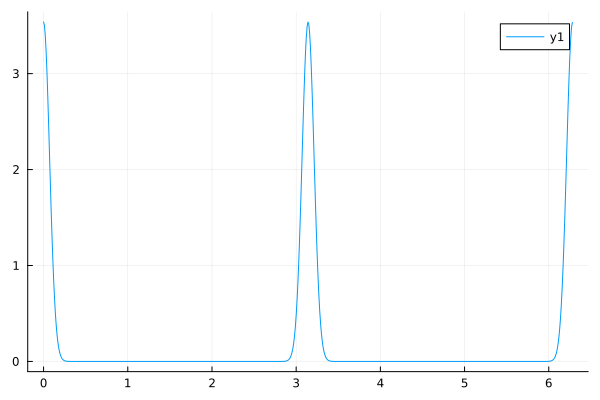

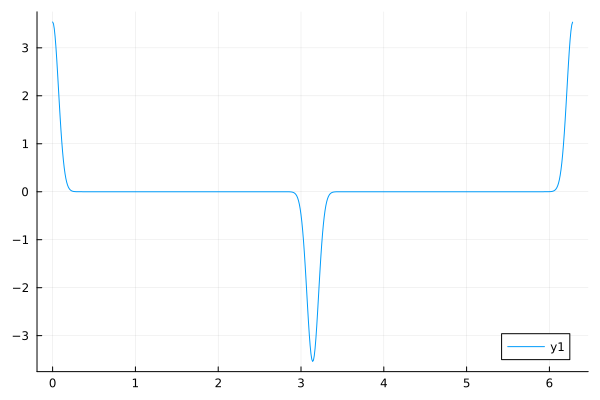

In [2]:
using MathieuFunctions
function ce(m::Int64, q::Real, x::AbstractVector{Float64})
    accuracy = 0.00001
    if m%2 == 0
        a = charA(q, k=m:m+1)[1]
        A = [0., 1., 0., a/q, 0., ((a-4.)*a/(q*q))-2., 0.]
        i = 8
        #Normalization as each new coefficient is computed:
        N = 2*A[2]^2 + sum(A[4:end].^2)
        A = A ./sqrt(N)
        while (abs(A[i-2])>accuracy)
            push!(A, ((a-(i-4.)*(i-4.))/q)*A[i-2]- A[i-4])
            push!(A, 0.)
            N = 2*A[2]^2 + sum(A[4:end].^2)
            A = A ./sqrt(N)
            i += 2
        end
        t = zeros(length(x))
        for j in 2:length(A)
            t += A[j]*cos.((j-2)*x)
        end
        return t
    end
    if m%2 == 1
        a = charA(q, k=m:m+1)[1]
        A = [1., 0., (a-q-1.)/q, 0., ((a-9.)/q)*((a-q-1.)/q)-1., 0., ((a-25.)/q)*(((a-9.)/q)*((a-q-1.)/q)-1.)-(a-q-1.)/q, 0.]
        i = 9
        #Normalization as each new coefficient is computed:
        N = sum(A[1:end].^2)
        A = A ./sqrt(N)
        while (abs(A[i-2])>accuracy)
            push!(A, ((a-(i-2)*(i-2))/q)*A[i-2] - A[i-4])
            push!(A, 0.)
            N = sum(A[1:end].^2)
            A = A ./sqrt(N)
            i += 2
        end
        t = zeros(length(x))
        for j in 1:length(A)
            t += A[j]*cos.((j)*x)
        end
        return t
    end
end

#Mathieu sine function:
function se(m::Int64, q::Real, x::AbstractVector{Float64})
    accuracy = 0.00001
    if m%2 == 0
        a = charB(q, k=m:m)[1]
        B = [0., 1., 0., (a-4.)/q, 0.]
        i = 6
        #Normalization as each new coefficient is computed:
        N = sum(B[2:end].^2)
        B = B ./sqrt(N)
        while (abs(B[i-2])>accuracy)
            push!(B, ((a-(i-2.)*(i-2.))/q)*B[i-2]- B[i-4])
            push!(B, 0.)
            N = sum(B[2:end].^2)
            B = B ./sqrt(N)
            i += 2
        end
        t = zeros(length(x))
        for j in 2:length(B)
            t += B[j]*sin.((j)*x)
        end
        return t
    end
    if m%2 == 1
        a = charB(q, k=m:m)[1]
        B = [1., 0., (a+q-1.)/q, 0.]
        i = 5
        #Normalization as each new coefficient is computed:
        N = sum(B[1:end].^2)
        B = B ./sqrt(N)
        while (abs(B[i-2])>accuracy)
            push!(B, ((a-(i-2)*(i-2))/q)*B[i-2] - B[i-4])
            push!(B, 0.)
            N = sum(B[1:end].^2)
            B = B ./sqrt(N)
            i += 2
        end
        t = zeros(length(x))
        for j in 1:length(B)
            t += B[j]*sin.((j)*x)
        end
        return t
    end
end

using Plots

x = 0:0.01:2π
p = plot(x, ce(0, -10000, x))
display(p)
plot(x, ce(1, -10000, x))


In [27]:
# comparing the N=2 case with the Mathieu functions
using MathieuFunctions

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))

f (generic function with 1 method)

In [29]:
using LaTeXStrings
using Plots

# pyplot()
function filter_checkerboard(x)
    xlen, ylen = size(x)
    output = zeros(xlen*ylen ÷ 2)
    k = 1
    for i=1:xlen
        for j=1:ylen
            if (i÷2 + (j÷2))%2 == 0
                # println(i," ",j)
                output[k] = x[i,j]
                k += 1
            end
        end
    end 
    return output
end

# ENV["GKS_FONT_DIRS"] = pwd()
# using GR
# font = loadfont("times.ttf")
# settextfontprec(font, GR.TEXT_PRECISION_OUTLINE)

# PyPlot.matplotlib[:rc]("text", usetex=true)
# p = plot(xlabel=L"$g$", ylabel=L"E", legend=nothing, fontfamily="times", dpi=300)
g_values = 10000:10000
data = reduce(vcat,transpose.([collect(Iterators.flatten(filter_checkerboard(f(g/2) .+ f(3/2*g)') ./2)) for g in g_values]))
data = data[:, sortperm(data[1,:])]
data[1,1:15]
# for i in 1:20
#     plot!(p, g_values, data[:,i])
# end
# display(p)
# savefig("2024_06_13_mathieu_N=2_ed.png")

15-element Vector{Float64}:
 -19807.065184864172
 -19807.06518486414
 -19666.1456130133
 -19666.14561301326
 -19562.617236716105
 -19562.61723671607
 -19525.730083207174
 -19525.730083207138
 -19421.69766486523
 -19421.69766486519
 -19385.821344074015
 -19385.82134407398
 -19318.671606303815
 -19318.67160630381
 -19281.282135059104

In [33]:
g = -10000
println((charA(3g/2;k=1:1) .+charA(g/2;k=1:1))./2)
println((charA(3g/2;k=1:1) .+ charB(g/2;k=1:1))./2)
println((charB(3g/2;k=1:1) .+ charA(g/2;k=1:1))./2)
println((charB(3g/2;k=1:1) .+ charB(g/2;k=1:1))./2)


[-19807.065184864143]
[-19666.145613013265]
[-19562.617236716036]
[-19421.697664865154]


In [34]:
using MathieuFunctions
g = -10000

println((charA(3g/2;k=0:1)[1:1] .+charB(g/2;k=2:2))./2)
println((charA(3g/2;k=0:1)[1:1] .+charA(g/2;k=2:2))./2)
println((charB(3g/2;k=2:2) .+ charA(g/2;k=0:1)[1:1])./2)
println((charA(3g/2;k=2:2) .+ charA(g/2;k=0:1)[1:1])./2)


[-19666.14561301329]
[-19525.730083207163]
[-19562.61723671608]
[-19318.67160630381]


In [114]:
println((charB(3g/2;k=2:2) .+ charB(g/2;k=2:2))./2)
println((charB(3g/2;k=2:2) .+ charA(g/2;k=2:2))./2)
println((charA(3g/2;k=2:2) .+ charB(g/2;k=2:2))./2)
println((charA(3g/2;k=2:2) .+charA(g/2;k=2:2))./2)


[3.9958348149383482]
[3.9983320434386638]
[4.018114288884016]
[4.0206115173843315]


In [115]:
g = 1
sort(collect(Iterators.flatten(filter_checkerboard(f(g/2) .+ f(3/2*g)') ./2)))[1:20]

20-element Vector{Float64}:
 -0.5292920195323532
 -0.13130539915481576
  0.36675084463629193
  1.3182971325595956
  1.5211853608138712
  1.5820410507184333
  1.8163533763507034
  1.8462626628111247
  2.3125069615871534
  3.896740043157349
  3.957595733061911
  4.140227342838456
  4.142170887277014
  4.362984341933378
  4.42384003183794
  4.781631387399349
  4.831977701307232
  5.279687631190457
  5.33003394509834
  5.589829874552867

# DVR

In [137]:
mmax = 5
Nsites = 3
angle = 0
Estrength = 0
g = 0.2
pairs = "nearest"
energies = 20

dimension_parity = "even"
if dimension_parity  == "even"
    dim = 2*mmax
else
    dim = 2*mmax+1
end
initial_state = rand(ComplexF64, dim^Nsites)
H(x) = Hamiltonian_DVR(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs, dimension_parity=dimension_parity)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp

real.(vals)

20-element Vector{Float64}:
 -0.0500271344815974
  0.6869949071290381
  0.8350465527251626
  0.973745824374143
  0.9887331464191884
  1.1163442768039404
  1.2494835997113551
  1.7116001916798473
  1.7531993274944244
  1.765070197631326
  1.8508746557466769
  1.975187992954469
  1.9823973441390037
  1.9872473371234334
  1.9946583177411763
  2.129635498383006
  2.199051480615601
  2.212255480690583
  2.272504146090297
  2.95681918513012

In [135]:
H_mat = permutedims(hcat([H(x) for x in eachrow(Matrix{Float64}(I,dim^Nsites,dim^Nsites))]...))
norm(H_mat*op-op*H_mat)

8.94427190999916

In [115]:
function phiRotationOperator(dim)
	@assert dim % 2 == 0
	arr = zeros(dim,dim)
	for i = 1:dim
		arr[i, (i+dim÷2-1)%dim+1] = 1
	end
	return arr
end
P = (I + kron(phiRotationOperator(2*mmax), phiRotationOperator(2*mmax)))./2
P*op*vecs[1]

16-element Vector{ComplexF64}:
   8.962830477798889e-13 - 2.9995450567810167e-13im
   8.988469690773826e-15 - 3.0184188481996443e-15im
  1.4072944198861848e-16 - 1.951563910473908e-17im
      8.975459264704e-15 - 3.073929999430902e-15im
   8.988469690773826e-15 - 3.0192862099376327e-15im
 -1.9447876468958736e-17 - 7.210622073386408e-17im
  -8.971556136883052e-15 + 2.9629076969683865e-15im
   8.115253261054001e-17 - 4.228388472693467e-18im
  1.4072944198861848e-16 - 1.951563910473908e-17im
      8.975459264704e-15 - 3.073929999430902e-15im
   8.962830477798889e-13 - 2.9995450567810167e-13im
   8.988469690773826e-15 - 3.0184188481996443e-15im
  -8.971556136883052e-15 + 2.9629076969683865e-15im
   8.115253261054001e-17 - 4.228388472693467e-18im
   8.988469690773826e-15 - 3.0192862099376327e-15im
 -1.9447876468958736e-17 - 7.210622073386408e-17im

In [132]:
mat = dvr_rotation_symmetry(dim^Nsites)
op = spzeros(dim^Nsites, dim^Nsites) # swaps symmetry
op[diagind(op)] = [[1 for _ in 1:dim^Nsites÷2];[-1 for _ in 1:dim^Nsites÷2]]
H(op*vecs[1])./(op*vecs[1])

16-element Vector{ComplexF64}:
 0.9875306622462854 - 9.401860594900842e-16im
 1.0927863053654974 + 1.1193693085811834e-15im
 0.9861516839363961 - 1.783033142347416e-15im
  0.893471287738201 + 5.187321186107928e-16im
 0.8005661052757249 + 8.190507135959881e-17im
 0.9944195673836264 - 6.610879097494728e-16im
 1.2006914716763877 + 8.736540945023871e-16im
  0.994356708298556 - 3.641909828497445e-16im
 0.9861516839363985 + 6.044180143550563e-16im
 0.8934712877382035 - 7.917490231427881e-16im
 0.9875306622462882 + 1.5587295196809271e-15im
  1.092786305365498 - 5.733354995171916e-16im
 1.2006914716763857 - 7.64447332689589e-16im
 0.9943567082985548 + 1.4307502897668537e-15im
  0.800566105275722 - 1.5015929749259795e-15im
 0.9944195673836245 + 8.910315305318989e-16im

In [11]:
# inversion_projection_dvr(vecs[energy_level]; Nsites, mmax, parity="odd", direction="LR")
energy_level = 1
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=dim)
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    # println(data/dim*360, " ", abs.(vecs[energy_level][indices][end-i])^2, " ")
    println(data/dim*360, " ", real.(vecs[energy_level][indices][end-i]/vecs[energy_level][indices][end]), " ")
end



[0.0, 0.0] 1.0 
[180.0, 180.0] 0.999998962382915 
[16.363636363636363, 0.0] 0.7611751034571396 
[0.0, 343.6363636363636] 0.7611751034571302 
[0.0, 16.363636363636363] 0.7611751034571186 
[343.6363636363636, 0.0] 0.7611751034571101 
[180.0, 163.63636363636363] 0.7611743136488466 
[196.36363636363635, 180.0] 0.7611743136488451 
[163.63636363636363, 180.0] 0.7611743136488384 
[180.0, 196.36363636363635] 0.761174313648825 
[16.363636363636363, 343.6363636363636] 0.6739570092260048 
[343.6363636363636, 16.363636363636363] 0.6739570092259692 
[196.36363636363635, 163.63636363636363] 0.6739563099167181 
[163.63636363636363, 196.36363636363635] 0.6739563099166933 
[16.363636363636363, 16.363636363636363] 0.5009567678934701 
[343.6363636363636, 343.6363636363636] 0.5009567678934602 
[163.63636363636363, 163.63636363636363] 0.5009562480921693 
[196.36363636363635, 196.36363636363635] 0.5009562480921594 
[32.72727272727273, 343.6363636363636] 0.3486689835648236 
[16.363636363636363, 327.272727272

In [17]:
# inversion_projection_dvr(vecs[energy_level]; Nsites, mmax, parity="odd", direction="LR")
energy_level = 2
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=dim)
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    # println(data/dim*360, " ", abs.(vecs[energy_level][indices][end-i])^2, " ")
    println(data/dim*360, " ", real.(vecs[energy_level][indices][end-i]/vecs[energy_level][indices][end]), " ")
end



[180.0, 180.0] 1.0 
[0.0, 0.0] -0.9999990859250175 
[180.0, 196.36363636363635] 0.7611750993331955 
[196.36363636363635, 180.0] 0.7611750993331847 
[180.0, 163.63636363636363] -0.761175099333172 
[163.63636363636363, 180.0] -0.7611750993331656 
[343.6363636363636, 0.0] 0.7611744035620753 
[0.0, 343.6363636363636] 0.7611744035620629 
[0.0, 16.363636363636363] -0.7611744035620571 
[16.363636363636363, 0.0] -0.7611744035620507 
[163.63636363636363, 196.36363636363635] -0.6739569885792972 
[196.36363636363635, 163.63636363636363] -0.6739569885792934 
[343.6363636363636, 16.363636363636363] 0.6739563725320626 
[16.363636363636363, 343.6363636363636] 0.6739563725320509 
[196.36363636363635, 196.36363636363635] 0.5009567677545937 
[163.63636363636363, 163.63636363636363] 0.5009567677545649 
[343.6363636363636, 343.6363636363636] -0.5009563098425409 
[16.363636363636363, 16.363636363636363] -0.5009563098425212 
[163.63636363636363, 212.72727272727275] -0.3486689478014571 
[196.36363636363635, 

In [77]:
hist_data = zeros(dim, Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=dim)
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

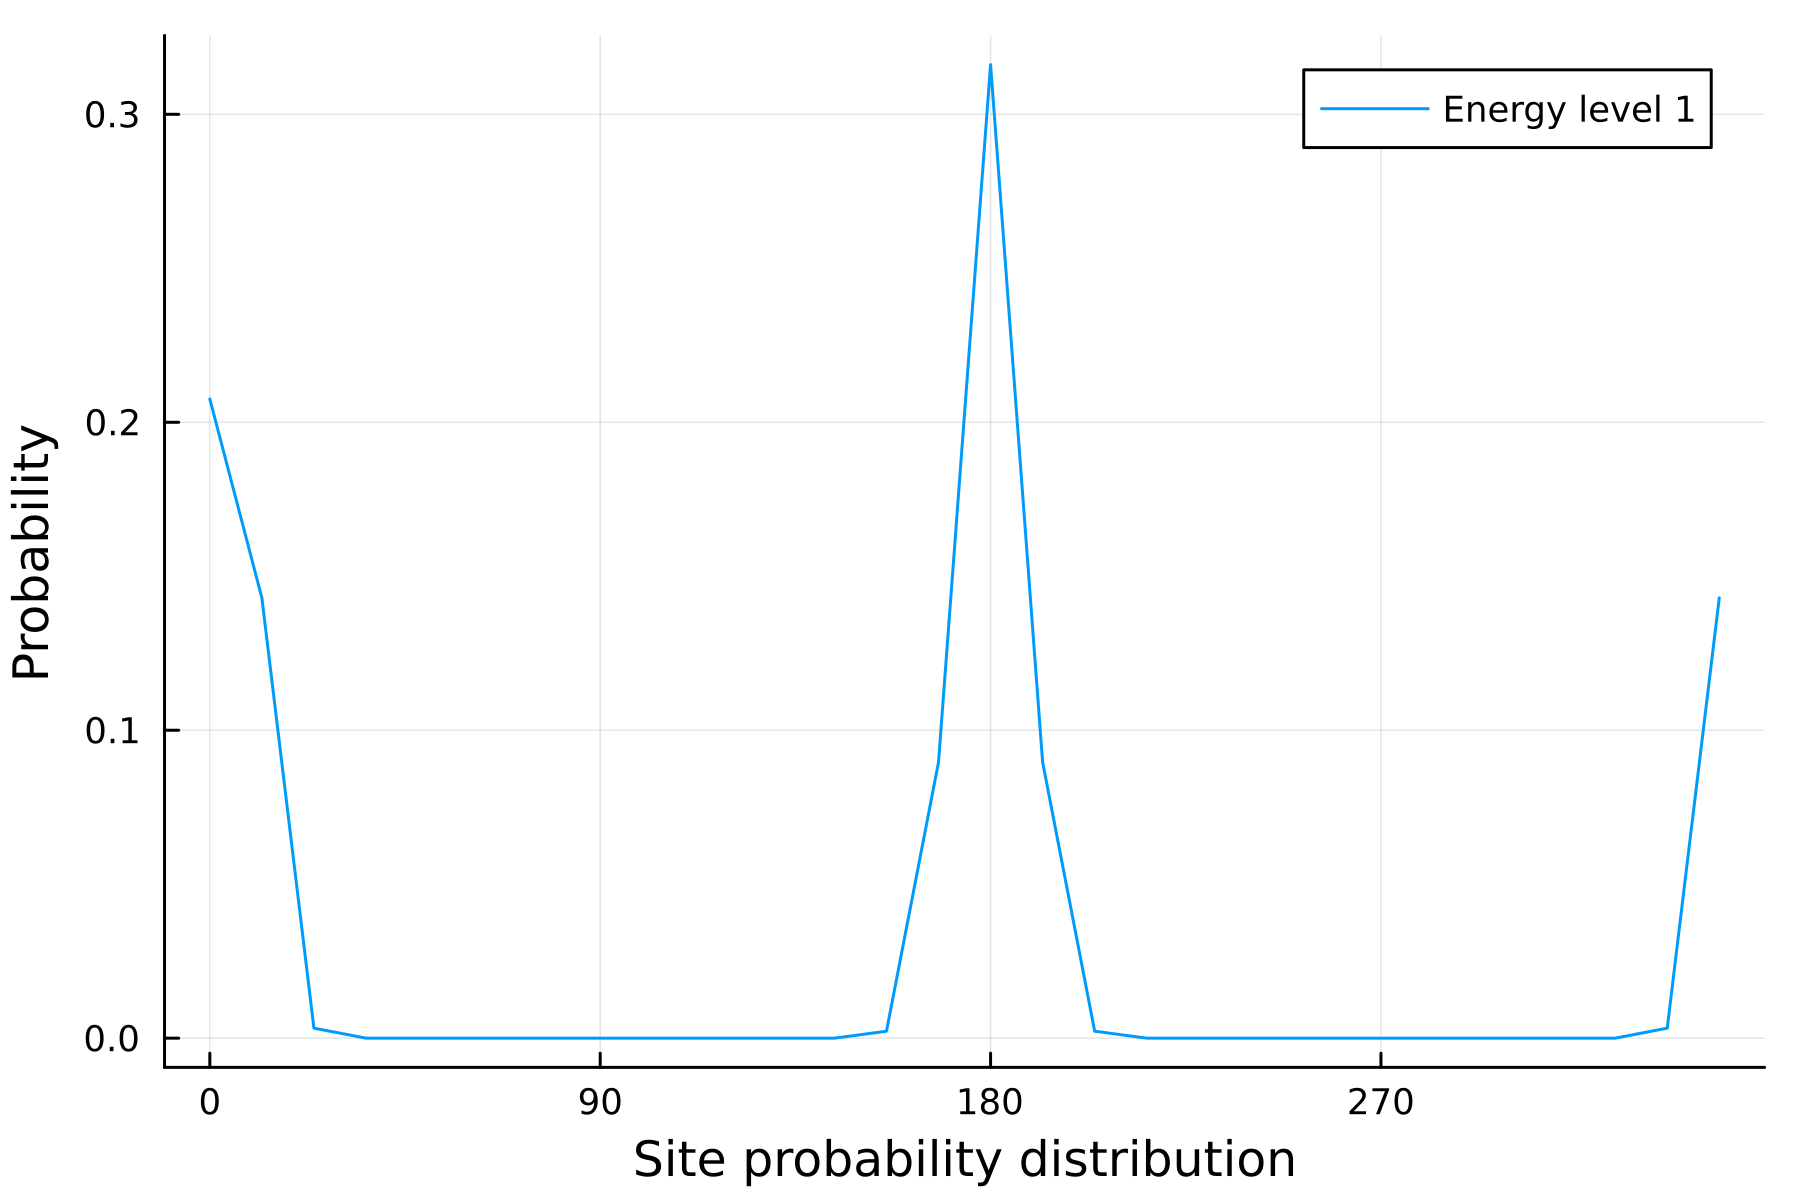

In [78]:
using Plots

# data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",dpi=300, xticks=([0,90,180,270,360]))
for (i,energy_level) in enumerate(1:1)
    data = hist_data[:,2,energy_level]
    # bar!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
    # label=string("Energy level ", energy_level), bar_width = 360/length(data))
    plot!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
        label=string("Energy level ", energy_level))
end
display(p)
# savefig("2024_05_31_single_site2_4_probability_DVR_dist_g=30_mmax=7.png")

In [32]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_reflection = sum(abs.(reflection_projection(vec; Nsites, dim, parity="even").^2))
    even_inversion_dvr = sum(abs.(inversion_projection_dvr(vec; Nsites, dim, parity="even").^2))
    println(@sprintf("%d - energy: %0.3f - reflection (even): %d - inversion_dvr (even): %d", i, real(energy), even_reflection, even_inversion_dvr))
end

1 - energy: -0.000 - reflection (even): 1 - inversion_dvr (even): 1
2 - energy: 1.000 - reflection (even): 1 - inversion_dvr (even): 1
3 - energy: 1.000 - reflection (even): 0 - inversion_dvr (even): 0
4 - energy: 1.000 - reflection (even): 1 - inversion_dvr (even): 0
5 - energy: 1.000 - reflection (even): 0 - inversion_dvr (even): 1
6 - energy: 2.000 - reflection (even): 0 - inversion_dvr (even): 0
7 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 1
8 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 0
9 - energy: 2.000 - reflection (even): 1 - inversion_dvr (even): 1
10 - energy: 4.000 - reflection (even): 0 - inversion_dvr (even): 1
11 - energy: 4.000 - reflection (even): 1 - inversion_dvr (even): 0
12 - energy: 4.000 - reflection (even): 0 - inversion_dvr (even): 0
13 - energy: 4.000 - reflection (even): 1 - inversion_dvr (even): 1
14 - energy: 5.000 - reflection (even): 0 - inversion_dvr (even): 0
15 - energy: 5.000 - reflection (even): 0 - inversion_dv

# M basis

In [5]:
mmax = 9
Nsites = 3
angle = 0
Estrength = 0

pairs = "nearest"
energies = 20

g = 0.24
dim = 2*mmax+1
initial_state = rand(ComplexF64, (2*mmax+1)^Nsites)
H(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp
real.(vals)

InexactError: InexactError: Float64(64.45205410956123 + 16.099927366905256im)

In [6]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_inversion = Int(round(sum(abs.(inversion_projection_m(vec; Nsites, dim, parity="even").^2))))
    even_reflection = Int(round(sum(abs.(reflection_projection(vec; Nsites, dim, parity="even").^2))))
    even_parity = Int(round(sum(abs.(parity_projection_m(vec; Nsites, dim, parity="even").^2))))
    println(@sprintf("%d - energy: %0.7f - parity (even): %d  - reflection (even): %d - inversion (even): %d", i, real(energy),even_parity,even_reflection, even_inversion ))
end

UndefVarError: UndefVarError: `vecs` not defined

In [ ]:
using KrylovKit
include("ed.jl")
using .observables

using Printf
using Logging
using ZChop
Logging.disable_logging(Logging.Warn)

In [72]:


mmax = 9
Nsites = 3
angle = 0
Estrength = 0

pairs = "nearest"
energies = 20

g = 0.25
dim = 2*mmax+1
initial_state = rand(ComplexF64, (2*mmax+1)^Nsites)
H(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs2, info = tmp
# real.(vals)



for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_inversion = Int(round(sum(abs.(inversion_projection_m(vec; Nsites, dim, parity="even").^2))))
    even_parity = Int(round(sum(abs.(parity_projection_m(vec; Nsites, dim, parity="even").^2))))
    if !(even_inversion == 1 && even_parity == 1)
        continue
    end
    entropy, renyi, p = vN_entropy2(vec; Nsites, dim, split=1)
    corr = real(correlation(vec;Nsites, dim, axis="X"))
    println(@sprintf("%d - energy: %0.7f - entropy: %0.7f", i, real(energy),entropy))
    # println(p)
end

1 - energy: -0.0781729 - entropy: 0.1069226
8 - energy: 1.6386125 - entropy: 0.6637986
11 - energy: 1.8119991 - entropy: 0.6535584
13 - energy: 1.9724814 - entropy: 1.0407068
15 - energy: 1.9916443 - entropy: 1.0206138
16 - energy: 2.1576268 - entropy: 0.6620856
19 - energy: 2.3364893 - entropy: 0.6587304


In [108]:
function vN_entropy2(state::Vector{T}; Nsites, dim, split) where {T<:Number}
    state_matrix =  reshape(state,(dim^(Nsites-split),dim^split))'
    vector_size = dim^split # dim^(Nsites-split)
    n_singular_values = min(dim^(Nsites-split), dim^split)
    # using a random initial vector because that is unlikely to cause svdsolve to crash
    vals, _, _, _ = KrylovKit.svdsolve(state_matrix, vector_size, min(n_singular_values,30), :LR)

    SvN = 0.0
    renyi = 0.0
    p = vals.^2
    p ./= sum(p)
    for n in eachindex(vals)
        SvN -= p[n] * log(p[n])
        renyi += p[n]^2
    end
    renyi = - 0.5*log(renyi)
    # println(renyi)
    return SvN, renyi, p
end
vN_entropy2(vecs[2]; Nsites, dim, split=1)[1]


0.5994880985253837

0.12541640812075153

In [33]:
energy_level = 3
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = digits(indices[end - i]-1, base=2*mmax+1, pad=Nsites) .- mmax
    println(data, " ", real.(vecs[energy_level][indices][end-i]/vecs[energy_level][indices][end]))
    # println(data, " ", p[end-i])
end


[0, 0, 0, 0, 0, -1] 1.0
[0, 0, 0, 0, 0, 1] -0.9999999999999611
[1, 0, 0, 0, 0, 0] 0.9999999999999014
[-1, 0, 0, 0, 0, 0] -0.9999999999998982
[1, 0, 0, -1, 0, -1] 0.9086703840925192
[1, 0, 1, 0, 0, -1] 0.9086703840925134
[-1, 0, 0, 1, 0, 1] -0.9086703840924562
[-1, 0, -1, 0, 0, 1] -0.9086703840924526
[0, -1, 0, -1, 0, -1] 0.8444660942570891
[1, 0, 1, 0, 1, 0] 0.8444660942570696
[0, 1, 0, 1, 0, 1] -0.8444660942570353
[-1, 0, -1, 0, -1, 0] -0.8444660942570248
[1, 0, 0, 0, 1, -1] 0.8268200573025991
[1, -1, 0, 0, 0, -1] 0.8268200573025856
[-1, 0, 0, 0, -1, 1] -0.826820057302542
[-1, 1, 0, 0, 0, 1] -0.8268200573025308
[0, -1, 1, 0, 0, -1] 0.8035637260740555
[1, 0, 0, -1, 1, 0] 0.803563726074046
[0, 1, -1, 0, 0, 1] -0.8035637260740081
[-1, 0, 0, 1, -1, 0] -0.8035637260740053
[0, -1, 0, 0, 1, -1] 0.7797490951622801


In [181]:
hist_data = zeros(Int(2*mmax+1), Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

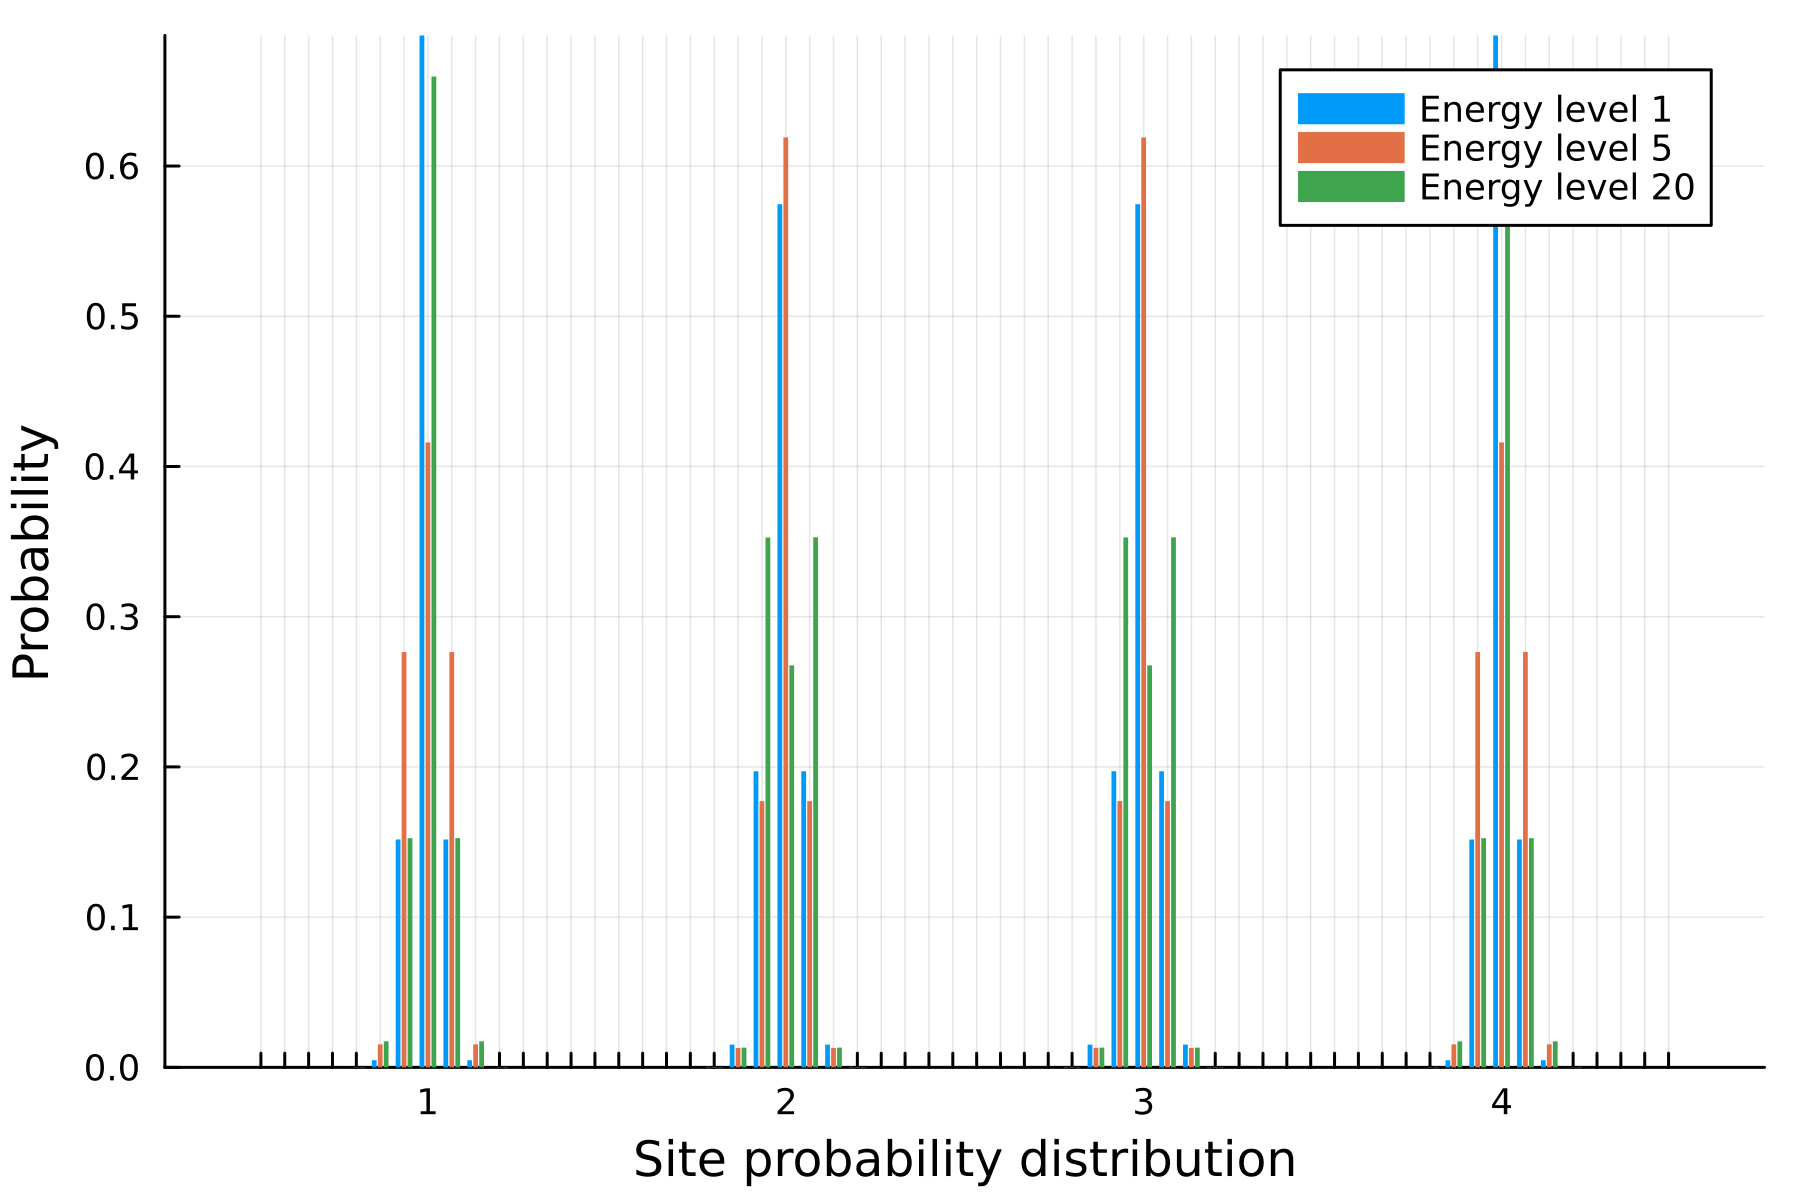

In [182]:
using Plots

data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",
xticks=(1:length(data),[(i-mmax-1)%(2*mmax+1)==0 ? (i ÷ (2*mmax+1))+1 : "" for i=1:length(data)]),dpi=300)
for (i,energy_level) in enumerate([1,5,20])
    data = hist_data[:,:,energy_level]
    bar!(p,float(1:length(data)) .+ (i-2)/4, reshape(data, length(data)), #alpha=0.6, 
    label=string("Energy level ", energy_level), bar_width = 0.2, linecolor=nothing)
end
display(p)
# savefig("2024_05_29_single_site_probability_dist_g=100.png")

# Comparing rotation and M parity symmetries

In [40]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    if (c+d)%2 == 1
        continue
    end 
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2a^2 + 2b^2 == (c^2+d^2) && (a+b)%2 != c%2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    # if !found
    #     println("DIDN'T WORK: c=$c d=$d")
    # end
end

In [44]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2(2a+1)^2 + 2(2b+1)^2 == (2c)^2+(2d)^2 || 2(2a)^2 + 2(2b)^2 == (2c)^2+(2d)^2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    if !found
        println("DIDN'T WORK: c=$c d=$d")
    end
end

c=0 d=0   a=0 b=0
c=1 d=0   a=0 b=0
c=2 d=0   a=1 b=1
c=3 d=0   a=1 b=1
c=4 d=0   a=2 b=2
c=5 d=0   a=3 b=0
c=6 d=0   a=3 b=3
c=7 d=0   a=3 b=3
c=8 d=0   a=4 b=4
c=9 d=0   a=4 b=4
c=10 d=0   a=7 b=1
c=11 d=0   a=5 b=5
c=12 d=0   a=6 b=6
c=13 d=0   a=8 b=3
c=14 d=0   a=7 b=7
c=15 d=0   a=10 b=1
c=16 d=0   a=8 b=8
c=17 d=0   a=11 b=3
c=18 d=0   a=9 b=9
c=19 d=0   a=9 b=9
c=20 d=0   a=14 b=2
c=0 d=1   a=0 b=0
c=1 d=1   a=1 b=0
c=2 d=1   a=1 b=0
c=3 d=1   a=2 b=1
c=4 d=1   a=2 b=1
c=5 d=1   a=3 b=2
c=6 d=1   a=3 b=2
c=7 d=1   a=5 b=0
c=8 d=1   a=5 b=1
c=9 d=1   a=5 b=4
c=10 d=1   a=5 b=4
c=11 d=1   a=6 b=5
c=12 d=1   a=8 b=0
c=13 d=1   a=9 b=2
c=14 d=1   a=7 b=6
c=15 d=1   a=8 b=7
c=16 d=1   a=8 b=7
c=17 d=1   a=12 b=1
c=18 d=1   a=12 b=2
c=19 d=1   a=10 b=9
c=20 d=1   a=10 b=9
c=0 d=2   a=1 b=1
c=1 d=2   a=1 b=0
c=2 d=2   a=2 b=0
c=3 d=2   a=2 b=0
c=4 d=2   a=3 b=1
c=5 d=2   a=3 b=1
c=6 d=2   a=4 b=2
c=7 d=2   a=4 b=2
c=8 d=2   a=5 b=3
c=9 d=2   a=6 b=0
c=10 d=2   a=6 b=4
c=11 d=2   a=7 b

In [43]:
for (c,d) in Tuple.(CartesianIndices((0:20, 0:20)))
    found = false
    for (a,b) in Tuple.(CartesianIndices((0:20, 0:20)))
        if 2(2a+1)^2 + 2(2b)^2 == (2c+1)^2+(2d+1)^2
            println("c=$c d=$d   a=$a b=$b")
            found = true
            break
        end
    end
    if !found
        println("DIDN'T WORK: c=$c d=$d")
    end
end

c=0 d=0   a=0 b=0
c=1 d=0   a=0 b=1
c=2 d=0   a=1 b=1
c=3 d=0   a=2 b=0
c=4 d=0   a=2 b=2
c=5 d=0   a=2 b=3
c=6 d=0   a=4 b=1
c=7 d=0   a=3 b=4
c=8 d=0   a=4 b=4
c=9 d=0   a=4 b=5
c=10 d=0   a=5 b=5
c=11 d=0   a=5 b=6
c=12 d=0   a=6 b=6
c=13 d=0   a=9 b=1
c=14 d=0   a=7 b=7
c=15 d=0   a=7 b=8
c=16 d=0   a=11 b=2
c=17 d=0   a=8 b=9
c=18 d=0   a=9 b=9
c=19 d=0   a=9 b=10
c=20 d=0   a=14 b=0
c=0 d=1   a=0 b=1
c=1 d=1   a=1 b=0
c=2 d=1   a=0 b=2
c=3 d=1   a=2 b=1
c=4 d=1   a=1 b=3
c=5 d=1   a=3 b=2
c=6 d=1   a=2 b=4
c=7 d=1   a=4 b=3
c=8 d=1   a=3 b=5
c=9 d=1   a=6 b=2
c=10 d=1   a=7 b=0
c=11 d=1   a=6 b=5
c=12 d=1   a=5 b=7
c=13 d=1   a=7 b=6
c=14 d=1   a=9 b=4
c=15 d=1   a=8 b=7
c=16 d=1   a=7 b=9
c=17 d=1   a=9 b=8
c=18 d=1   a=12 b=4
c=19 d=1   a=13 b=3
c=20 d=1   a=14 b=1
c=0 d=2   a=1 b=1
c=1 d=2   a=0 b=2
c=2 d=2   a=2 b=0
c=3 d=2   a=0 b=3
c=4 d=2   a=3 b=1
c=5 d=2   a=1 b=4
c=6 d=2   a=4 b=2
c=7 d=2   a=5 b=1
c=8 d=2   a=5 b=3
c=9 d=2   a=3 b=6
c=10 d=2   a=6 b=4
c=11 d=2   a=4 b=

# Computing symmetries

In [1]:
using LinearAlgebra
using ZChop

function generate_symmetries(H)
    #https://iopscience.iop.org/article/10.1088/1367-2630/aadf67/pdf
    nx, ny = size(H)
    commutations = []
    symmetries = []
    L = []

    # compute all hermitian matrices and their commutations relations with H
    for i=1:nx
        for j=i:nx
            for val in [1, 1im]
                tmp = zeros(ComplexF64, (nx, ny))
                # ensuring zero trace in all hermitian matrices
                if i!=j
                    tmp[i,j] += val
                    tmp[j,i] += conj(val)
                elseif i == 1 || val == 1im # make sure you ignore the complex part when i=j
                    continue
                else
                    tmp[1,1] = -1
                    tmp[i,i] = 1
                end

                comm = tmp*H - H*tmp
                if all(isapprox.(comm,0.0;atol=1e-14))
                    push!(symmetries, tmp) 
                else
                    push!(commutations, comm)
                    push!(L, tmp)
                end
            end
        end
    end

    commutations = reshape(cat(commutations...;dims=3),nx*nx,length(L))
    if length(commutations) == 0
        return symmetries
    end

    # find real superposition of the commutation relations that make the commutation relation 0
    vecs = nullspace(vcat(real.(commutations),imag.(commutations)))
    if length(vecs) == 0
        return []
    end
    new_symmetries = sum(vecs .* L,dims=1)[1,:]
    return [symmetries;new_symmetries]
end
function mutually_commute_symmetries(symmetries)
    # https://iopscience.iop.org/article/10.1088/1367-2630/aadf67/pdf
    A = mapreduce(permutedims, vcat, ([-1im*reshape(a*b-b*a, length(a)) for a in symmetries for b in symmetries]))
    if all(isapprox.(abs.(A),0.0;atol=1e-14))
        return symmetries
    end
    L = mapreduce(permutedims, vcat, map(x->reshape(x, length(x)),symmetries))
    f = (A' \ L' )
    f_reshaped = reshape(f,length(symmetries),length(f)÷length(symmetries))
    K = f_reshaped*f_reshaped'
    l = nullspace(vcat(real.(K), imag.(K)))
    new_symmetries = [sum(vec.*symmetries) for vec in eachcol(l)]
    return new_symmetries
end


mutually_commute_symmetries (generic function with 1 method)

In [23]:
# using Tensorial
# using TensorOperations
using Kronecker

id = Matrix{Float64}(I, 2,2)
Z = [1 0; 0 -1]
X = [0 1; 1 0]
id = Matrix{Float64}(I, 2,2)
# H = Z ⊗ Z ⊗ id + id ⊗ Z ⊗ Z  + id ⊗ X ⊗ id +  id ⊗ id ⊗ X + X ⊗ id ⊗ id 
H = Z ⊗ Z  + id ⊗ X + X ⊗ id
X_sym = X ⊗ X
tmp_sym = generate_symmetries(H)
# sym = mutually_commute_symmetries(tmp_sym)

3-element Vector{Any}:
 ComplexF64[0.03263392268732118 + 0.0im -0.37637715361540325 + 0.0im -0.3763771536154031 - 5.551115123125783e-17im -0.6276270788493776 - 1.373011566974688e-16im; -0.37637715361540325 + 0.0im -0.032633922687321015 + 0.0im 0.19039507375607145 + 1.4429124114947477e-17im -0.3763771536154029 - 5.960368860968747e-18im; -0.3763771536154031 + 5.551115123125783e-17im 0.19039507375607145 - 1.4429124114947477e-17im -0.032633922687321903 + 0.0im -0.37637715361540236 + 7.477856436161365e-17im; -0.6276270788493776 + 1.373011566974688e-16im -0.3763771536154029 + 5.960368860968747e-18im -0.37637715361540236 - 7.477856436161365e-17im 0.03263392268732174 + 0.0im]
 ComplexF64[0.3886344124118929 + 0.0im 0.07689099398033951 + 4.163336342344337e-17im 0.07689099398033972 - 1.1102230246251565e-16im 0.09376432673237631 - 1.9712799347858102e-16im; 0.07689099398033951 - 4.163336342344337e-17im -0.38863441241189234 + 0.0im 0.7172511635954829 + 1.03655008405544e-16im 0.07689099398033916 - 5.

In [22]:
Z ⊗ Z  + id ⊗ X + X ⊗ id

4×4 Matrix{Float64}:
 1.0   1.0   1.0  0.0
 1.0  -1.0   0.0  1.0
 1.0   0.0  -1.0  1.0
 0.0   1.0   1.0  1.0

In [113]:
# H*X_sym - X_sym*H
V = eigvecs(tmp_sym[1])
show(stdout, "text/plain", zchop(inv(V)*H*V))

8×8 Matrix{ComplexF64}:
 2.60388+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im  -0.109916+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im     0.109916+0.0im  6.89973e-14+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im  6.89527e-14+0.0im          1.0+0.0im       0.0+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im  -3.49396+0.0im   0.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im  -1.0+0.0im       0.0+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im       0.0+0.0im   0.0+0.0im  -2.60388+0.0im      0.0+0.0im
     0.0+0.0im        0.0+0.0im          0.0+0.0im          0.0+0.0im    

In [34]:
_, v = eigen(tmp_sym[1])
a = mapreduce(permutedims, vcat, [diag(inv(v)*s*v) for s in tmp_sym])'
p0 = nullspace(a)
for m in CartesianIndices(Tuple([(-1:2:1) for i in 1:size(a)[1]]))

    # if sum(collect(Tuple(m))) != 0 || m[1] == 1
    #     continue
    # end
    p = a \ (collect(Tuple(m)))
    
    U = exp(1im*π/2* sum(tmp_sym.*p))*1im
    # show(stdout, "text/plain", zchop(U))
    # println()
    # real.(zchop(U))
    # println(zchop(real.(U)))

    # show(stdout, "text/plain", real.(zchop(U)))
    # println()
    # println(m)

    if zchop(U)[2] == 0
        println(eigvals(U))
        show(stdout, "text/plain", real.(zchop(U)))
        println()
        # println(real.(eigvals(U)))
    end
end
# real.(U^4)

ComplexF64[-1.1102230246251565e-16 + 0.9999999999999989im, -8.326672684688674e-17 + 1.0im, 4.17734363090045e-17 + 1.0im, 7.177418381854039e-17 + 0.9999999999999998im]
4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
ComplexF64[-0.7071067811865477 - 0.707106781186547im, 0.707106781186547 + 0.7071067811865481im, 0.7071067811865477 + 0.7071067811865477im, 0.7071067811865479 + 0.7071067811865475im]
4×4 Matrix{Float64}:
 0.707107  0.0       0.0       0.0
 0.0       0.0       0.707107  0.0
 0.0       0.707107  0.0       0.0
 0.0       0.0       0.0       0.707107
ComplexF64[-1.0000000000000004 + 8.326672684688674e-16im, -1.0 + 4.440892098500627e-16im, 0.9999999999999996 + 1.2230808674527723e-15im, 1.0000000000000004 - 1.986531206576165e-16im]
4×4 Matrix{Float64}:
  0.0   0.0   0.0  -1.0
  0.0   0.0  -1.0   0.0
  0.0  -1.0   0.0   0.0
 -1.0   0.0   0.0   0.0
ComplexF64[-0.7071067811865487 + 0.7071067811865461im, -0.7071067811865479 + 0.70710

In [25]:


mmax = 1
Nsites = 2
angle = 0
Estrength = 0
pairs = "nearest"
energies = 20
g = 1
dim = 2*mmax+1
H = Matrix{ComplexF64}(I, (2*mmax+1)^Nsites,(2*mmax+1)^Nsites)
new_hamiltonian(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
for i=1:(2*mmax+1)^Nsites
    H[i,:] = new_hamiltonian(H[i,:])
end
tmp_sym = generate_symmetries(H)
# symmetries = mutually_commute_symmetries(tmp_sym)

20-element Vector{Any}:
 ComplexF64[0.023912644833546493 + 0.0im -0.11546355433142108 - 0.21280069043240168im … -0.11546355433142098 - 0.21280069043240185im -0.18335378942244204 + 0.007726138168080511im; -0.11546355433142108 + 0.21280069043240168im -0.06603310411907344 + 0.0im … 0.07997590274680058 + 1.341158087364569e-16im 0.0693150520000138 - 0.16092631192840018im; … ; -0.11546355433142098 + 0.21280069043240185im 0.07997590274680058 - 1.341158087364569e-16im … -0.06603310411907332 + 0.0im 0.0693150520000138 - 0.16092631192840018im; -0.18335378942244204 - 0.007726138168080511im 0.0693150520000138 + 0.16092631192840018im … 0.0693150520000138 + 0.16092631192840018im 0.15334777470687855 + 0.0im]
 ComplexF64[-0.29937997106918146 + 0.0im 0.02628340650343843 + 0.02204649139141035im … 0.02628340650343808 + 0.022046491391410475im -0.029109697821527305 - 0.03002909021843766im; 0.02628340650343843 - 0.02204649139141035im 0.052650676882666315 + 0.0im … -0.08305606818454178 + 6.877229905347115e-1

In [26]:
A = mapreduce(permutedims, vcat, ([-1im*reshape(a*b-b*a, length(a)) for a in tmp_sym for b in tmp_sym]))
L = mapreduce(permutedims, vcat, map(x->reshape(x, length(x)),tmp_sym))
f = (A' \ L' )
f_reshaped = reshape(f,length(tmp_sym),length(f)÷length(tmp_sym))
K = f_reshaped*f_reshaped'
l = nullspace(vcat(real.(K), imag.(K)))
new_symmetries = [sum(vec.*tmp_sym) for vec in eachcol(l)]

5-element Vector{Matrix{ComplexF64}}:
 [0.09480032955701027 + 0.0im 2.0816681711721685e-17 - 1.2576745200831851e-17im … 7.895323433762418e-17 + 6.591949208711867e-17im 0.3540785782403896 - 6.938893903907228e-18im; 2.0816681711721685e-17 + 1.2576745200831851e-17im -0.11161728094634525 + 0.0im … 0.12869391307523753 - 9.409118657350646e-17im -1.8214596497756474e-17 - 3.0357660829594124e-17im; … ; 7.895323433762418e-17 - 6.591949208711867e-17im 0.12869391307523753 + 9.409118657350646e-17im … -0.11161728094634521 + 0.0im -8.890457814381136e-17 - 5.4643789493269423e-17im; 0.3540785782403896 + 6.938893903907228e-18im -1.8214596497756474e-17 + 3.0357660829594124e-17im … -8.890457814381136e-17 + 5.4643789493269423e-17im 0.09480032955701058 + 0.0im]
 [0.35535141452988367 + 0.0im -6.245004513516506e-17 - 7.025630077706069e-17im … 8.517093970969666e-17 - 1.5352302762394743e-16im 0.13849441342267754 - 1.457167719820518e-16im; -6.245004513516506e-17 + 7.025630077706069e-17im -0.29716916797182447 + 0

In [158]:
H = [
4 1 0 0 0 0 0;
1 2 1 0 0 0 0;
0 1 1 1 0 0 0;
0 0 1 0 1 0 0;
0 0 0 1 1 1 0;
0 0 0 0 1 2 1;
0 0 0 0 0 1 4;
]
s = generate_symmetries(H)
# s = mutually_commute_symmetries(s)
# s[1]*s[6]-s[6]*s[1]
exp(1im*s[2])

7×7 Matrix{ComplexF64}:
    0.898515+0.120744im     …    -0.054583+0.292806im
   0.0132065+0.000102791im     -0.00530945+0.17216im
  -0.0134037+0.0251281im         -0.011791+0.204151im
  -0.0170296+0.128907im         -0.0170296+0.128907im
   -0.011791+0.204151im         -0.0134037+0.0251281im
 -0.00530945+0.17216im      …    0.0132065+0.000102791im
   -0.054583+0.292806im           0.898515+0.120744im

In [188]:
using ZChop
check_all_zero = x-> all(isapprox.(x,0.0;atol=1e-14))
U = exp(1im*symmetries[1])
U

25×25 Matrix{ComplexF64}:
       0.9933+8.50481e-5im   …   0.000151642-0.111217im
 -1.47745e-16-1.7473e-17im       3.53116e-16+1.07343e-16im
   0.00522418+0.00422432im       -0.00466344-0.0143173im
  2.76383e-17+6.54907e-17im      4.58301e-17+1.53777e-17im
   4.87065e-5-0.00114554im        4.87065e-5-0.00114554im
  4.87181e-17-8.45396e-18im  …  -1.11222e-16-1.62268e-16im
  -0.00271582-0.0161859im        -0.00124002+0.00338036im
 -3.14061e-16+3.70664e-18im      3.21255e-16-1.32529e-17im
  -8.36252e-5+0.00451516im       -8.36252e-5+0.00451516im
  2.07038e-16-6.70041e-17im     -2.66441e-19-5.31875e-17im
             ⋮               ⋱  
  -8.36252e-5+0.00451516im       -8.36252e-5+0.00451516im
 -3.71962e-16-1.38723e-17im      3.64021e-16-3.02242e-17im
  -0.00124002+0.00338036im       -0.00271582-0.0161859im
  2.07608e-16+3.98649e-17im     -1.86084e-17+2.61596e-17im
   4.87065e-5-0.00114554im   …    4.87065e-5-0.00114554im
  1.23473e-16+7.01838e-17im     -7.31886e-17-4.82101e-17im
  -0.0046

# Parity swap operator

In [36]:
function m_inversion_symmetry(Nspec)
	@assert Nspec%2 == 1
	operator = zeros(Nspec, Nspec)
	for i in 1:Nspec÷2
		operator[i,i] = 1/sqrt(2)
		operator[i,end-i+1] = 1/sqrt(2)
		operator[end-i+1,end-i+1] = -1/sqrt(2)
		operator[end-i+1,i] = 1/sqrt(2)
	end
	operator[Nspec÷2+1, Nspec÷2+1] = 1
	return operator
end
function Xoperator(dim)

	diagonal = zeros(dim)
	subdiagonal = 0.5*ones(dim - 1)

	matrix=Tridiagonal(subdiagonal,diagonal,subdiagonal)

	return matrix
end
#################################################################
function Yoperator(dim)

	diagonal = zeros(dim)
	upper_subdiagonal = 0.5*ones(dim-1)

	matrix=Tridiagonal(-upper_subdiagonal,diagonal,upper_subdiagonal)

	return matrix
end
using LinearAlgebra
using ZChop

X = rotr90(Matrix{Float64}(I,5,5))
P = m_inversion_symmetry(5)
M = zchop(P*X*P')
Xop = Xoperator(5)
Yop = Yoperator(5)


5×5 Tridiagonal{Float64, Vector{Float64}}:
  0.0   0.5    ⋅     ⋅    ⋅ 
 -0.5   0.0   0.5    ⋅    ⋅ 
   ⋅   -0.5   0.0   0.5   ⋅ 
   ⋅     ⋅   -0.5   0.0  0.5
   ⋅     ⋅     ⋅   -0.5  0.0

In [59]:
bigM = kron(M,M)
V = kron(Xop,Xop)-2*kron(Yop,Yop)
show(stdout, "text/plain", zchop(bigM*V-V*bigM))

25×25 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  -0.5  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  -1.5   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.5  0.0  0.0  0.0   0.0   0.0

In [70]:
state = rand(5)
state ./= sqrt(sum(abs.(state).^2))

5-element Vector{Float64}:
 0.1887150176932171
 0.5424694046991692
 0.733731684656453
 0.35806671454512357
 0.05949478908645817

In [82]:
((I+X)/2)*M*((I+X)/2)*state

5-element Vector{Float64}:
 0.0
 0.0
 0.733731684656453
 0.0
 0.0

In [95]:
function dvr_rotation_symmetry(Nspec)
	mmax = Nspec÷2
	@assert Nspec%2 == 0
	operator = zeros(Nspec, Nspec)
	for i in 1:mmax
		operator[i,i] = 1/sqrt(2)
		operator[i,i+mmax] = 1/sqrt(2)
		operator[i+mmax,i] = 1/sqrt(2)
		operator[i+mmax,i+mmax] = -1/sqrt(2)
	end
	return operator
end
function exp_dvr(dim)
	N = dim÷2
	#Write DVR grid and position operators on grid#
	phi = zeros(dim)
	X = zeros((dim,dim))
	Y = zeros((dim,dim))
	
	for ii=1:dim
		phi[ii] = (ii-1)*2.0*pi/dim
		X[ii,ii] = cos(phi[ii])	
		Y[ii,ii] = sin(phi[ii])	
	end
	
	#Write kinetic energy matrix in DVR basis#
	T = zeros((dim,dim))
	
	for ii=1:dim
		for jj=ii:dim
			if dim%2 == 0
				T[ii,jj] = 1/(2.0*sin(pi*(ii-jj)/dim)^2)*(-1.)^(ii-jj)
			else
				T[ii,jj] = cos(pi*(ii-jj)/dim)/(2.0*sin(pi*(ii-jj)/dim)^2)*(-1.)^(ii-jj)
			end
			T[jj,ii] = T[ii,jj]
		end
		if dim%2 == 0
			T[ii,ii] = (2N^2+1)/6
		else
			T[ii,ii] = N*(N+1)/3
		end
	end
	
	return T,X,Y
end
P = dvr_rotation_symmetry(6)
M = P'*[0 0 0 1 0 0;0 0 0 0 1 0; 0 0 0 0 0 1; 1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 1 0 0 0]*P
T,X,Y = exp_dvr(6)

([3.1666666666666665 -2.0000000000000004 … 0.6666666666666665 -2.0000000000000004; -2.0000000000000004 3.1666666666666665 … -0.5 0.6666666666666665; … ; 0.6666666666666665 -0.5 … 3.1666666666666665 -2.0000000000000004; -2.0000000000000004 0.6666666666666665 … -2.0000000000000004 3.1666666666666665], [1.0 0.0 … 0.0 0.0; 0.0 0.5000000000000001 … 0.0 0.0; … ; 0.0 0.0 … -0.5000000000000004 0.0; 0.0 0.0 … 0.0 0.5000000000000001], [0.0 0.0 … 0.0 0.0; 0.0 0.8660254037844386 … 0.0 0.0; … ; 0.0 0.0 … -0.8660254037844385 0.0; 0.0 0.0 … 0.0 -0.8660254037844386])

In [110]:
λ, V = eigen(T)
zchop(V'*M*V)*zchop(diagm(λ)) - zchop(diagm(λ))*zchop(V'*M*V)

6×6 Matrix{Float64}:
  0.0        0.471405   0.816497   0.0       0.0      -3.0
 -0.471405   0.0        0.0       -2.0       1.73205   0.0
 -0.816497   0.0        0.0        1.73205   0.0       0.0
  0.0        2.0       -1.73205    0.0       0.0       2.35702
  0.0       -1.73205    0.0        0.0       0.0       4.08248
  3.0        0.0        0.0       -2.35702  -4.08248   0.0

In [115]:
zchop(V'*X*V)

6×6 Matrix{Float64}:
  0.0       -0.353553   0.612372   0.0        0.0        0.0
 -0.353553   0.0        0.0        0.25       0.433013   0.0
  0.612372   0.0        0.0        0.433013  -0.25       0.0
  0.0        0.25       0.433013   0.0        0.0       -0.353553
  0.0        0.433013  -0.25       0.0        0.0        0.612372
  0.0        0.0        0.0       -0.353553   0.612372   0.0

In [104]:
norm(T*M-M*T)

9.177266598624135